# Fit the tdms linear model & predict single mutant effects + replay predictions

This notebook will fit the `torchdms` linear model and evaluate performance on:

1. The testing data held out
2. All octet data points
3. All replay sequences

In [1]:
# Imports
import pickle
import json
import os
from functools import reduce
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import torch
from Bio.Seq import Seq
from Bio import SeqIO
import binarymap
import glob
import gctree

%matplotlib inline

## 1: Merge and clean raw data

In [2]:
! ls data/torchdms/prepped-dms/

dms-baseline-drop-na  dms-octet.pkl  dms-strata-ceiling-3
dms-baseline-keep-na  dms-only.pkl   dms-strata-ceiling-4


In [3]:
model_prefix = "model-seed-7-lll"
outdir = "data/torchdms/prepped-dms/"
for dsdir in os.walk(outdir):
    if dsdir[0] == outdir: continue
    print(dsdir[0])

data/torchdms/prepped-dms/dms-baseline-keep-na
data/torchdms/prepped-dms/dms-strata-ceiling-4
data/torchdms/prepped-dms/dms-baseline-drop-na
data/torchdms/prepped-dms/dms-strata-ceiling-3


**define the model**

In [4]:
for dsdir in os.walk(outdir):
    if dsdir[0] == outdir: continue
    model_config = {
        "default": {
            "data_path": f"{dsdir[0]}/data.prepped.pkl",
            "epochs": 400,
            "independent_starts": 15,
            "include_details": True,
            "loss_fn": "mse",
            "min_lr": 1e-7,
            "non_lin_bias" : False,
            "output_bias" : False,
            "device" : "cpu",
            "model_string": "FullyConnected;[2];[None]",
            "prefix": f"{dsdir[0]}/{model_prefix}",
            "seed": 7
        }
    }
    with open(f"{dsdir[0]}/{model_prefix}-config.json", "w") as outfile:
        json.dump(model_config, outfile, indent=4)

In [28]:
! head data/torchdms/prepped-dms/dms-baseline-drop-na/nonlinear-model-training.log

LOG: Setting random seed to 23.
LOG: Model defined as: FullyConnected(
  (latent_layer): Linear(in_features=4935, out_features=2, bias=False)
  (nonlinearity_1): Linear(in_features=2, out_features=3, bias=False)
  (output_layer): Linear(in_features=3, out_features=2, bias=False)
)
{'activations': '[Identity(), <built-in method relu of type object at 0x7fba53fe5760>]', 'monotonic': None, 'beta_l1_coefficient': 0.0, 'interaction_l1_coefficient': 0.0, 'non-linearity bias parameters': False, 'output bias': False}
LOG: Saved model to data/torchdms/prepped-dms/dms-baseline-drop-na/nonlinear-model.model
LOG: Setting random seed to 23.
Starting training. {'independent_start_count': 15, 'independent_start_epoch_count': None, 'epoch_count': 500, 'loss_fn': <function weighted_loss.<locals>.wrapper at 0x7fb9ee94e310>, 'patience': 10, 'min_lr': 1e-05, 'loss_weight_span': None, 'exp_target': None, 'beta_rank': None}


**fit the models**

Here we will start by fitting three models, all of which are defined the same but with different training data. The architecture is simply the linear model with no bias on the output

In [6]:
for dsdir in os.walk(outdir):
    if dsdir[0] == outdir: continue
    ! tdms go --config {dsdir[0]}/{model_prefix}-config.json > {dsdir[0]}/{model_prefix}-training.log
    ! echo "===================================="
    ! echo {dsdir[0]}
    ! tail -n 20 {dsdir[0]}/{model_prefix}-training.log

data/torchdms/prepped-dms/dms-baseline-keep-na
validation loss record: 0.7856138944625854

validation loss record: 0.7811634540557861
Epoch 00343: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00354: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00365: reducing learning rate of group 0 to 1.0000e-06.
Epoch 00376: reducing learning rate of group 0 to 1.0000e-07.
Epoch 00387: reducing learning rate of group 0 to 1.0000e-08.
Learning rate dropped below stated minimum. Stopping.
LOG: error plot finished and dumped to data/torchdms/prepped-dms/dms-baseline-keep-na/model-seed-7-lll.error.pdf
LOG: scatter plot finished and dumped to data/torchdms/prepped-dms/dms-baseline-keep-na/model-seed-7-lll.scatter.pdf
LOG: loaded data, evaluating beta coeff for wildtype seq: EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLEYMGYISYSGSTYYNPSLKSRISITRDTSKNQYYLQLNSVTTEDTATYYCARDFDVWGAGTTVTVSSGGGGSGGGGSGGGGSDIVMTQSQKFMSTSVGDRVSVTCKASQNVGTNVAWYQQKPGQSPKALIYSASYRYSGVPDRFTGSGSGTDFTLTISNVQSEDLAEYF

First let's try with octet +  data

**look at test results - did we break the wall?**

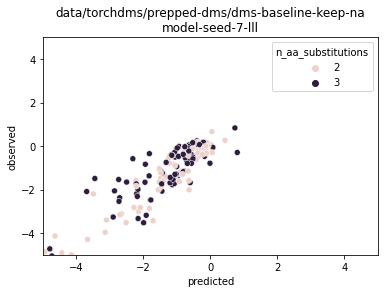

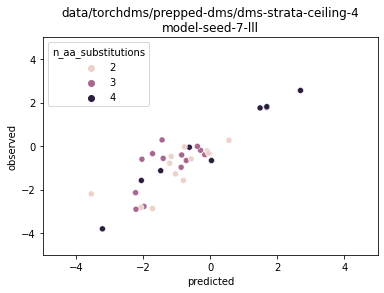

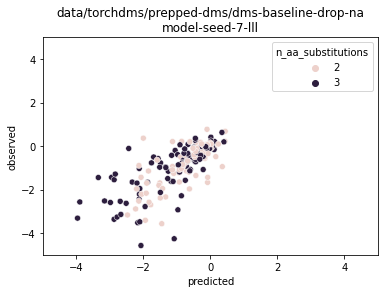

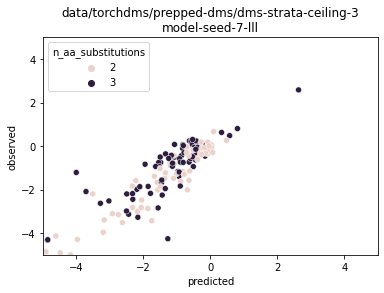

In [7]:
# if this works we can also always just show the correlation plots, at least in the slides?.
for dsdir in os.walk(outdir):
    if dsdir[0] == outdir: continue
    results = pd.read_csv(f"{dsdir[0]}/{model_prefix}.error.csv")
    fig, ax = plt.subplots()
    g = sns.scatterplot(data=results, y="observed", x="predicted", hue="n_aa_substitutions", ax=ax)
    g.set_ylim((-5, 5))
    g.set_xlim((-5, 5))
    g.set_title(f"{dsdir[0]}\n{model_prefix}")
    plt.show()
    saveto = f"{dsdir[0]}/{model_prefix}-testset-scatter.png"
    fig.savefig(saveto)

# 10: predict on new data

In [8]:
octet_df = pd.read_csv(f"data/torchdms/raw-dms/octet_data.csv")

In [9]:
dms_df = pd.read_csv("https://media.githubusercontent.com/media/jbloomlab/Ab-CGGnaive_DMS/main/results/final_variant_scores/final_variant_scores.csv", index_col="mutation", dtype=dict(position_IMGT=pd.Int16Dtype()))
# remove linker sites
dms_df = dms_df[dms_df.chain != "link"]
# add indicator for wildtype data
dms_df["WT"] = dms_df.wildtype == dms_df.mutant
assert dms_df.position_IMGT.max() < 1000
dms_df["site"] = [f"{chain}-{str(pos).zfill(3)}" for chain, pos in zip(dms_df.chain, dms_df.position_IMGT)]
dms_df

,target,wildtype,position,position_IMGT,chain,annotation,mutant,codon,single_nt,bind,...,expr,delta_expr,n_bc_expr,n_libs_expr,psr,delta_psr,n_bc_psr,n_libs_psr,WT,site
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,FWRH1,A,GAG,True,10.48829,...,10.44614,-0.00453,19.0,2.0,6.78608,-0.07452,17.0,2.0,False,H-001
E1(H)C,CGG_naive,E,1,1,H,FWRH1,C,GAG,False,10.44477,...,10.32364,-0.12703,20.0,2.0,7.44234,0.58174,17.0,2.0,False,H-001
E1(H)D,CGG_naive,E,1,1,H,FWRH1,D,GAG,True,10.42771,...,10.51618,0.06551,16.0,2.0,6.95940,0.09880,13.0,2.0,False,H-001
E1(H)E,CGG_naive,E,1,1,H,FWRH1,E,GAG,True,10.45719,...,10.45067,0.00000,21170.0,2.0,6.86060,0.00000,18910.0,2.0,True,H-001
E1(H)F,CGG_naive,E,1,1,H,FWRH1,F,GAG,False,10.51899,...,10.33163,-0.11904,24.0,2.0,6.91372,0.05313,21.0,2.0,False,H-001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R124(L)S,CGG_naive,R,235,124,L,FWRL4,S,CGT,True,10.44756,...,10.54313,0.09246,39.0,2.0,6.93925,0.07866,33.0,2.0,False,L-124
R124(L)T,CGG_naive,R,235,124,L,FWRL4,T,CGT,False,10.43023,...,10.53860,0.08793,36.0,2.0,6.88956,0.02896,34.0,2.0,False,L-124
R124(L)V,CGG_naive,R,235,124,L,FWRL4,V,CGT,False,10.38231,...,10.48707,0.03640,27.0,2.0,6.78160,-0.07899,24.0,2.0,False,L-124


In [10]:
pos_df = pd.read_csv("https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/main/data/CGGnaive_sites.csv", dtype=dict(site=pd.Int16Dtype()), index_col="site_scFv")
pos_df

,amino_acid,chain,site,KI_codon,annotation
site_scFv,,,,,
1,E,H,1,GAG,FWRH1
2,V,H,2,GTG,FWRH1
3,Q,H,3,CAG,FWRH1
4,L,H,4,CTT,FWRH1
5,Q,H,5,CAG,FWRH1
...,...,...,...,...,...
231,L,L,120,CTA,FWRL4
232,E,L,121,GAA,FWRL4
233,I,L,122,ATA,FWRL4


data/torchdms/prepped-dms/dms-baseline-keep-na
data/torchdms/prepped-dms/dms-strata-ceiling-4
data/torchdms/prepped-dms/dms-baseline-drop-na
data/torchdms/prepped-dms/dms-strata-ceiling-3


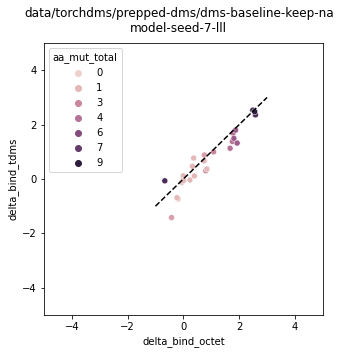

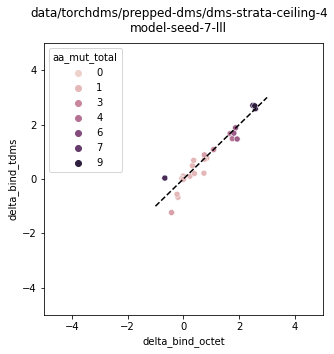

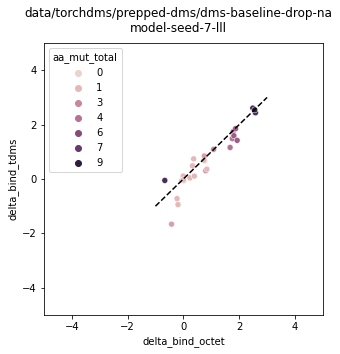

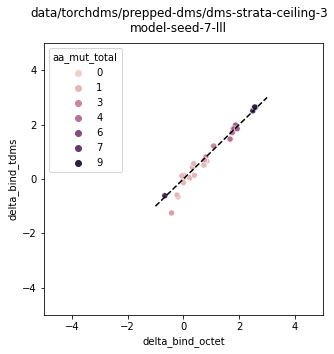

In [11]:
for dsdir in os.walk(outdir):
    if dsdir[0] == outdir: continue
    tdms_model = torch.load(f"{dsdir[0]}/{model_prefix}.model", map_location=torch.device('cpu'))
    print(dsdir[0])

    for row_idx, row in octet_df.iterrows():
        igh_mutations = [f"{(y := x.rstrip(','))[:-1]}(H){y[-1]}".rstrip(",") for x in row.HCmut.split() if "GL" not in x]
        igk_mutations = [f"{(y := x.rstrip(','))[:-1]}(L){y[-1]}".rstrip(",") for x in row.LCmut.split() if "GL" not in x]
        all_mutations = igh_mutations + igk_mutations
        if any("*" in x for x in all_mutations):
            delta_bind = None
        else:
            delta_bind = dms_df.delta_bind[all_mutations].sum()
        octet_df.loc[row_idx, "delta_bind_additive"] = delta_bind

        aa_seq = pos_df.amino_acid.copy()
    #     print(aa_seq)
        for mutation in all_mutations:
            chain = mutation[-3]
            pos = int(mutation[1:-4])
            wildtype = mutation[0]
            mutant = mutation[-1]
            idx = pos_df.index[(pos_df.site == pos) & (pos_df.chain == chain)]
            assert len(idx) == 1
            idx = idx[0]
            assert aa_seq[idx] == wildtype
            aa_seq[idx] = mutant
    #     print(tdms_model.seq_to_binary("".join(aa_seq)).sum())
        tdms_prediction = tdms_model(tdms_model.seq_to_binary("".join(aa_seq))).detach()# - tdms_prediction_naive
        octet_df.loc[row_idx, "delta_bind_tdms"] = tdms_prediction[0].item()

    octet_df["delta_bind_octet"] = np.log10(octet_df.octet_Kd_foldchange_avg)

    fig, ax = plt.subplots(1, figsize=[5, 5])
    fig.suptitle(f"{dsdir[0]}\n{model_prefix}")
    sns.scatterplot(data=octet_df, y="delta_bind_tdms", x="delta_bind_octet", hue="aa_mut_total", ax=ax)
    ax.plot((-1, 3), (-1, 3), 'k--')
    ax.set_ylim((-5, 5))
    ax.set_xlim((-5, 5))
    
#     fig, ax = plt.subplots(1, 2, figsize=[10, 5])
#     fig.suptitle(f"{dsdir[0]}\n{model_prefix}")
#     sns.scatterplot(data=octet_df, y="delta_bind_additive", x="delta_bind_octet", hue="aa_mut_total", ax = ax[0])
#     ax[0].plot((-1, 3), (-1, 3), 'k--')
#     ax[0].set_ylim((-5, 5))
#     ax[0].set_xlim((-5, 5))
#     sns.scatterplot(data=octet_df, y="delta_bind_tdms", x="delta_bind_octet", hue="aa_mut_total", ax = ax[1])
#     ax[1].plot((-1, 3), (-1, 3), 'k--')
#     ax[1].set_ylim((-5, 5))
#     ax[1].set_xlim((-5, 5))

    saveto = f"{dsdir[0]}/{model_prefix}-octet-scatter.png"
    plt.savefig(saveto)
#     fig.savefig(f"{model_prefix}-pred-octet.pdf")

## Compare TorchDMS to naive additive model

on tree nodes

In [12]:
dms_df = pd.read_csv("https://media.githubusercontent.com/media/jbloomlab/Ab-CGGnaive_DMS/main/results/final_variant_scores/final_variant_scores.csv", index_col="mutation", dtype=dict(position_IMGT=pd.Int16Dtype()))
# remove linker sites
dms_df = dms_df[dms_df.chain != "link"]
# add indicator for wildtype data
dms_df["WT"] = dms_df.wildtype == dms_df.mutant
assert dms_df.position_IMGT.max() < 1000
dms_df["site"] = [f"{chain}-{str(pos).zfill(3)}" for chain, pos in zip(dms_df.chain, dms_df.position_IMGT)]
dms_df

,target,wildtype,position,position_IMGT,chain,annotation,mutant,codon,single_nt,bind,...,expr,delta_expr,n_bc_expr,n_libs_expr,psr,delta_psr,n_bc_psr,n_libs_psr,WT,site
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,FWRH1,A,GAG,True,10.48829,...,10.44614,-0.00453,19.0,2.0,6.78608,-0.07452,17.0,2.0,False,H-001
E1(H)C,CGG_naive,E,1,1,H,FWRH1,C,GAG,False,10.44477,...,10.32364,-0.12703,20.0,2.0,7.44234,0.58174,17.0,2.0,False,H-001
E1(H)D,CGG_naive,E,1,1,H,FWRH1,D,GAG,True,10.42771,...,10.51618,0.06551,16.0,2.0,6.95940,0.09880,13.0,2.0,False,H-001
E1(H)E,CGG_naive,E,1,1,H,FWRH1,E,GAG,True,10.45719,...,10.45067,0.00000,21170.0,2.0,6.86060,0.00000,18910.0,2.0,True,H-001
E1(H)F,CGG_naive,E,1,1,H,FWRH1,F,GAG,False,10.51899,...,10.33163,-0.11904,24.0,2.0,6.91372,0.05313,21.0,2.0,False,H-001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R124(L)S,CGG_naive,R,235,124,L,FWRL4,S,CGT,True,10.44756,...,10.54313,0.09246,39.0,2.0,6.93925,0.07866,33.0,2.0,False,L-124
R124(L)T,CGG_naive,R,235,124,L,FWRL4,T,CGT,False,10.43023,...,10.53860,0.08793,36.0,2.0,6.88956,0.02896,34.0,2.0,False,L-124
R124(L)V,CGG_naive,R,235,124,L,FWRL4,V,CGT,False,10.38231,...,10.48707,0.03640,27.0,2.0,6.78160,-0.07899,24.0,2.0,False,L-124


## Position maps for scFv

In [13]:
pos_df = pd.read_csv("https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/main/data/CGGnaive_sites.csv", dtype=dict(site=pd.Int16Dtype()), index_col="site_scFv")
pos_df

,amino_acid,chain,site,KI_codon,annotation
site_scFv,,,,,
1,E,H,1,GAG,FWRH1
2,V,H,2,GTG,FWRH1
3,Q,H,3,CAG,FWRH1
4,L,H,4,CTT,FWRH1
5,Q,H,5,CAG,FWRH1
...,...,...,...,...,...
231,L,L,120,CTA,FWRL4
232,E,L,121,GAA,FWRL4
233,I,L,122,ATA,FWRL4


In [14]:
pos_df[(pos_df.chain=="L")]

,amino_acid,chain,site,KI_codon,annotation
site_scFv,,,,,
128,D,L,1,GAC,FWRL1
129,I,L,2,ATT,FWRL1
130,V,L,3,GTG,FWRL1
131,M,L,4,ATG,FWRL1
132,T,L,5,ACT,FWRL1
...,...,...,...,...,...
231,L,L,120,CTA,FWRL4
232,E,L,121,GAA,FWRL4
233,I,L,122,ATA,FWRL4


### Add CDR/FWR annotations from IMGT VQUEST

In [15]:
# pos_df.loc[(pos_df.chain == "H") & (pos_df.site <= 26), "region"] = "FR1"
# pos_df.loc[(pos_df.chain == "H") & (27 <= pos_df.site) & (pos_df.site <= 38), "region"] = "CDR1"
# pos_df.loc[(pos_df.chain == "H") & (39 <= pos_df.site) & (pos_df.site <= 55), "region"] = "FR2"
# pos_df.loc[(pos_df.chain == "H") & (56 <= pos_df.site) & (pos_df.site <= 65), "region"] = "CDR2"
# pos_df.loc[(pos_df.chain == "H") & (66 <= pos_df.site) & (pos_df.site <= 104), "region"] = "FR3"
# pos_df.loc[(pos_df.chain == "H") & (105 <= pos_df.site) & (pos_df.site <= 110), "region"] = "CDR3"
# pos_df.loc[(pos_df.chain == "H") & (111 <= pos_df.site), "region"] = "FR4"

# pos_df.loc[(pos_df.chain == "L") & (pos_df.site <= 26), "region"] = "FR1"
# pos_df.loc[(pos_df.chain == "L") & (27 <= pos_df.site) & (pos_df.site <= 38), "region"] = "CDR1"
# pos_df.loc[(pos_df.chain == "L") & (39 <= pos_df.site) & (pos_df.site <= 55), "region"] = "FR2"
# pos_df.loc[(pos_df.chain == "L") & (56 <= pos_df.site) & (pos_df.site <= 65), "region"] = "CDR2"
# pos_df.loc[(pos_df.chain == "L") & (66 <= pos_df.site) & (pos_df.site <= 104), "region"] = "FR3"
# pos_df.loc[(pos_df.chain == "L") & (105 <= pos_df.site) & (pos_df.site <= 113), "region"] = "CDR3"
# pos_df.loc[(pos_df.chain == "L") & (114 <= pos_df.site) & (pos_df.site <= 123), "region"] = "FR4"
# pos_df.to_csv("output/CGGnaive_sites_annotated.csv")
pos_df

,amino_acid,chain,site,KI_codon,annotation
site_scFv,,,,,
1,E,H,1,GAG,FWRH1
2,V,H,2,GTG,FWRH1
3,Q,H,3,CAG,FWRH1
4,L,H,4,CTT,FWRH1
5,Q,H,5,CAG,FWRH1
...,...,...,...,...,...
231,L,L,120,CTA,FWRL4
232,E,L,121,GAA,FWRL4
233,I,L,122,ATA,FWRL4


In [16]:
igh_pos_map = pos_df.loc[pos_df.chain == "H", "site"].reset_index(drop=True)
igk_pos_map = pos_df.loc[pos_df.chain == "L", "site"].reset_index(drop=True)

In [17]:
import glob

In [18]:
date = "2022-03-28"

def gc_key(file):
    PR_str = file.split("/")[-2].split("-")
    return int(PR_str[1]), int(PR_str[3])

files = sorted(glob.glob(f"../nextflow/results/{date}/gctrees/PR*/gctree.p"), key=gc_key)
trees = {"_".join(f"{x}{y}" for x, y in zip(("mouse", "GC"), gc_key(file))): pickle.load(open(file, "rb"))
         for file in files}

print(f"loaded {len(trees)} GC trees")

loaded 74 GC trees


In [19]:
! ls ../nextflow/results

2022-03-22  2022-03-28	2022-04-01


**cell counts per gc**

<BarContainer object of 74 artists>

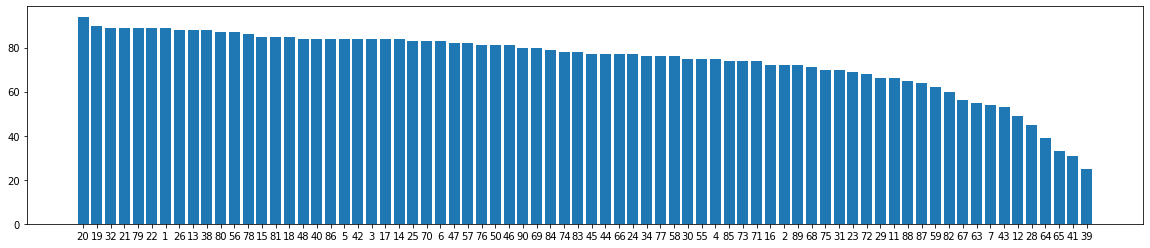

In [20]:
observed_bcrs = pd.read_csv(f"../nextflow/results/{date}/merged-results/observed-seqs.csv")
fig, ax = plt.subplots(figsize=[20, 4])
vc = observed_bcrs.HK_key_gc.value_counts().drop(0)
ax.bar([str(gc) for gc in vc.index], height=vc.values)

In [21]:
igh_frame = 1
igk_frame = 1
igk_idx = 336

In [22]:
τ = 1
τ0 = 0.1

In [23]:
def aa(seq, frame):
    return Seq(seq[(frame - 1) : (frame - 1 + (3 * ((len(seq) - (frame - 1)) // 3)))]).translate()

def mutations(naive_aa, aa, pos_map, chain_annotation):
    return [f"{aa1}{pos_map[pos]}{chain_annotation}{aa2}"
            for pos, (aa1, aa2) in enumerate(zip(naive_aa, aa))
            if aa1 != aa2]

def tree_nt_seq_to_dms_aa_seq(sequence):

    igh_aa = aa(sequence[:igk_idx], igh_frame)
    igk_aa = aa(sequence[igk_idx:], igk_frame)

    aa_dms = pos_df.amino_acid.copy()
    aa_dms.iloc[pos_df.chain == "H"] = igh_aa
    # note: replay light chains are shorter than dms seq by one aa
    aa_dms.iloc[(pos_df.chain == "L") & (pos_df.index < pos_df.index[-1])] = igk_aa
    
    return "".join(aa_dms)

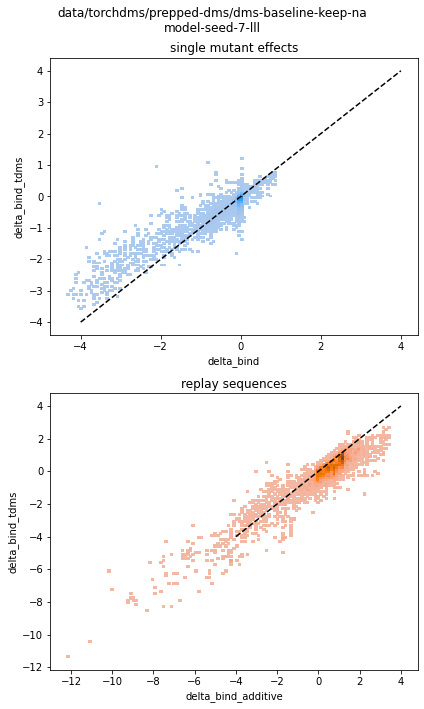

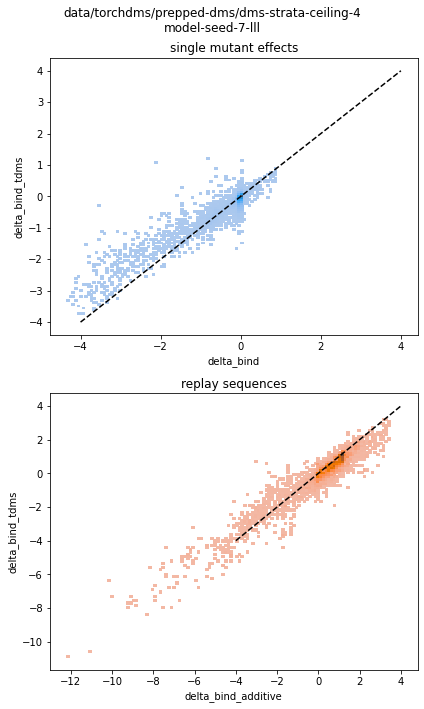

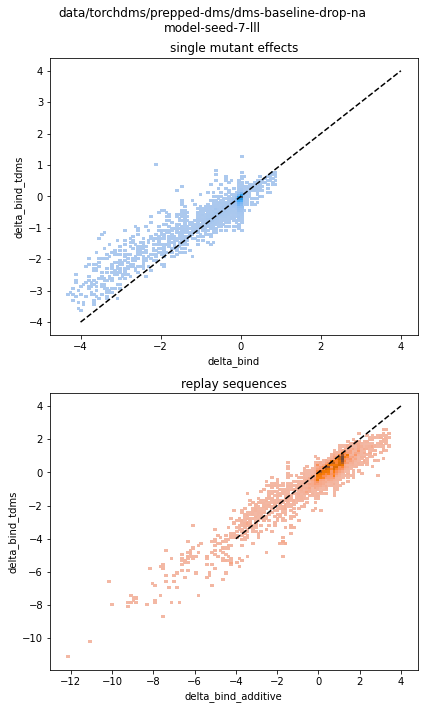

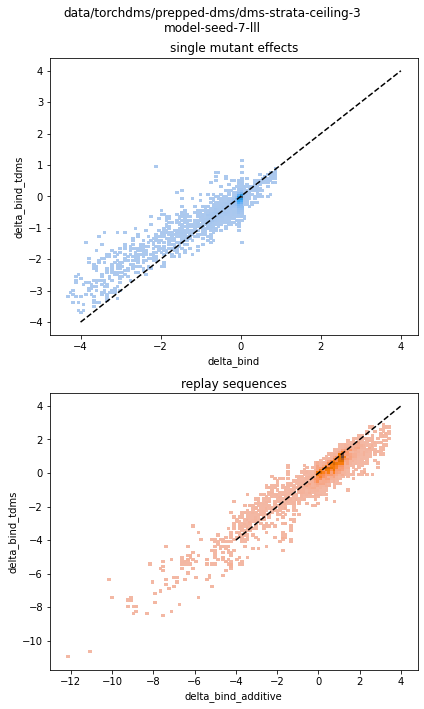

In [24]:
for dsdir in os.walk(outdir):
    if dsdir[0] == outdir: continue
    tdms_model = torch.load(f"{dsdir[0]}/{model_prefix}.model", map_location=torch.device('cpu'))

    for gc, tree in trees.items():

        # rename tuple names with last element of tuple (possible danger)
        if isinstance(tree.tree.name, tuple):
            tree.tree.name = tree.tree.name[-1]

        tree.local_branching(tau=τ, tau0=τ0)

        naive_igh_aa = aa(tree.tree.sequence[:igk_idx], igh_frame)
        naive_igk_aa = aa(tree.tree.sequence[igk_idx:], igk_frame)

        for node in tree.tree.traverse():

            igh_aa = aa(node.sequence[:igk_idx], igh_frame)
            igk_aa = aa(node.sequence[igk_idx:], igk_frame)
            igh_mutations = mutations(naive_igh_aa, igh_aa, igh_pos_map, "(H)")
            igk_mutations = mutations(naive_igk_aa, igk_aa, igk_pos_map, "(L)")        
            all_mutations = igh_mutations + igk_mutations
            if any("*" in x for x in all_mutations):
                delta_bind = np.nan
                delta_expr = np.nan
                delta_psr = np.nan
            else:
                delta_bind = dms_df.delta_bind[all_mutations].sum()
                delta_expr = dms_df.delta_expr[all_mutations].sum()
                delta_psr = dms_df.delta_psr[all_mutations].sum()

            node.add_feature("delta_bind_additive", delta_bind)
            node.add_feature("delta_expr_additive", delta_expr)
            node.add_feature("delta_psr_additive", delta_psr)

            tdms_prediction = tdms_model(tdms_model.seq_to_binary(tree_nt_seq_to_dms_aa_seq(node.sequence))).detach()# - tdms_prediction_naive

            node.add_feature("delta_bind_tdms", tdms_prediction[0].item())
            node.add_feature("delta_expr_tdms", tdms_prediction[1].item())


#         print(min((node.delta_bind_additive, (gc, node.name)) for gc, tree in trees.items() for node in tree.tree.traverse() if node.abundance))
    rows = []
    for gc, tree in trees.items():
        for node in tree.tree.traverse():
            if node.abundance:
                rows.append([node.delta_bind_tdms, node.delta_bind_additive, node.delta_expr_tdms, node.delta_expr_additive])

    tdmsVSadditive_df = pd.DataFrame(rows, columns=["delta_bind_tdms", "delta_bind_additive", "delta_expr_tdms", "delta_expr_additive"])
    
    def single_mut_seq(row):
        aa_seq = pos_df.amino_acid.copy()
        assert aa_seq[row.position] == row.wildtype
        aa_seq[row.position] = row.mutant
        aa_seq = "".join(aa_seq)
        tdms_prediction = tdms_model(tdms_model.seq_to_binary(aa_seq)).detach()
        return tdms_prediction

    dms_df[["delta_bind_tdms", "delta_expr_tdms"]] = dms_df.apply(
        single_mut_seq, axis=1, result_type="expand"
    )

    fig, ax = plt.subplots( 2, figsize=(6, 10))
    sns.histplot(
        data=dms_df, 
        x="delta_bind", 
        y="delta_bind_tdms", 
        color="C0",
        ax=ax[0]
    )
    ax[0].plot((-4, 4), (-4, 4), 'k--',)
    ax[0].set_title("single mutant effects")

    sns.histplot(
        data=tdmsVSadditive_df, 
        x="delta_bind_additive", 
        y="delta_bind_tdms", 
        color="C1",
        ax=ax[1]
    )
    ax[1].plot((-4, 4), (-4, 4), 'k--',)
    ax[1].set_title("replay sequences")


#     fig, ax = plt.subplots(2, 2, figsize=(6, 6))
    

#     sns.histplot(
#         data=dms_df, 
#         x="delta_bind", 
#         y="delta_bind_tdms", 
#         color="C0",
#         ax=ax[0, 0]
#     )
#     ax[0, 0].plot((-4, 4), (-4, 4), 'k--',)
#     plt.title("single mutant effects")

#     sns.histplot(
#         data=tdmsVSadditive_df, 
#         x="delta_bind_additive", 
#         y="delta_bind_tdms", 
#         color="C1",
#         ax=ax[0, 1]
#     )
#     ax[0, 1].plot((-4, 4), (-4, 4), 'k--',)
#     plt.title("replay sequences")

#     sns.histplot(
#         data=dms_df, 
#         x="delta_expr", 
#         y="delta_expr_tdms", 
#         color="C0",
#         ax=ax[1,0]
#     )
#     ax[1,0].plot((-4, 4), (-4, 4), 'k--',)

#     sns.histplot(
#         data=tdmsVSadditive_df, 
#         x="delta_expr_additive", 
#         y="delta_expr_tdms", 
#         color="C1",
#         ax=ax[1,1]
#     )
#     ax[1,1].plot((-4, 4), (-4, 4), 'k--',)

    fig.suptitle(f"{dsdir[0]}\n{model_prefix}")
    plt.tight_layout()
    plt.show()
    saveto = f"{dsdir[0]}/{model_prefix}-all-gctree-scatter.png"
    fig.savefig(saveto)
